Department of Physics, University of Pisa (AA 2022-2023)

### Multimessenger Physics Laboratory



## Data Analysis experience - Gravitational Waves 
#### (M. Razzano, Apr 26, 2023)

This notebook serves as a tutorial for the data analysis experience of gravitational wave events from coalescing systems. This is just an *outline* that shows how to use some of the most useful functions. 
For your analysis you can use the sample file contained in the *code* directory and start working on it. If you want to put some library functions in an external Python file that you will import as a module (with the import command), please feel free to do it.

**Do not forget** to add the extra files that you might use for the analysis, e.g. the data files to this Github repository in the data directory

More details are contained in the PDF file containing the description of this experience, that is available on Moodle (e-learning)

### Basic Setup
First of all, we import the required modules and we download the data file.

In [1]:
import os   #These two are useful modules
import sys

#here you can import other useful modules, such as numpy, matplotlib, etc..
import numpy as np #Numerical Python
import matplotlib.pyplot as plt

#also import astropy.fits
from astropy.io import fits
from gwpy.plot import Plot

**Important** Within the notebook you can run BASH command, by putting a ! before the command. For instance, if you want to run a ls command, type !ls

### Let's set some useful variables
The data are stored in a "data" directory at the same level of the "code" directory where you are now. Let's do some work to navigate the directory...
We will use the *os* module, in particular the *os.path* submodule.

**Note**: In this case we define the directories directly in this notebook, instead of using environment variables. For this examples, it is easier...

In [2]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data")
print("Data directory is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created!" % results_dir)
else:
    print("Results directory is %s" % data_dir)
    

I am in dir /home/jovyan/astrophysics_2023/experience---gw-data-analysis/tutorials
Main directory is /home/jovyan/astrophysics_2023/experience---gw-data-analysis
Data directory is /home/jovyan/astrophysics_2023/experience---gw-data-analysis/data
Results directory is /home/jovyan/astrophysics_2023/experience---gw-data-analysis/data


### Let's get started
After this basic setup, here below you can find some examples of analysis command

### Explore the GWOSC event dataset
Here we explore what events are on GWOSC and retrieve their data

In [3]:
#explore the events in the dataset
from gwosc.datasets import find_datasets
events = find_datasets(type="event")
print(events)

['151008-v1', '151012.2-v1', '151116-v1', '161202-v1', '161217-v1', '170208-v1', '170219-v1', '170405-v1', '170412-v1', '170423-v1', '170616-v1', '170630-v1', '170705-v1', '170720-v1', '190924_232654-v1', '191118_212859-v1', '191223_014159-v1', '191225_215715-v1', '200114_020818-v1', '200121_031748-v1', '200201_203549-v1', '200214_224526-v1', '200214_224526-v2', '200219_201407-v1', '200311_103121-v1', 'GRB051103-v1', 'GW150914-v1', 'GW150914-v2', 'GW150914-v3', 'GW151012-v1', 'GW151012-v2', 'GW151012-v3', 'GW151226-v1', 'GW151226-v2', 'GW170104-v1', 'GW170104-v2', 'GW170608-v1', 'GW170608-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v1', 'GW170814-v2', 'GW170814-v3', 'GW170817-v1', 'GW170817-v2', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1', 'GW190403_051519-v1', 'GW190408_181802-v1', 'GW190408_181802-v2', 'GW190412-v1', 'GW190412-v2', 'GW190412-v3', 'GW190412_053044-v4', 'GW190413_052954-v1', 'GW190413_052954-v2', 'GW190413_134308-v1', 'GW190413_134308-v2', 'GW190421_213

In [4]:
#Let's see the data relative to the first detection
#you will receive a list of files, that you could download in your data dir for future use,
#or just use the fetch command (see below) to use the files in real time 
ev_name = "GW150914"


#interferometer to use
ev_ifo = "L1"


from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls

ev_gps = event_gps(ev_name)
event_urls = get_event_urls(ev_name)

print("%s,%.1f,%s" % (ev_name,ev_gps,event_urls))

GW150914,1126259462.4,['https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5']


### Some basic operations on signal processing
Here we will select a time frame and see how we can have a quick look at the signal and do some basic filtering

In [7]:
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag

# Select a time interval of 30 mins around the event. This is because on GWOSC there is 1 hour data window released around events
dt_win=3600*0.25
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

print("Done")

Get data for GW150914 (L1) GPS: 1126258562.40 - 1126260362.40
Done


In [8]:
# data into samples of 90 seconds each
sample_duration = 90
num_samples = int((ev_t0_max - ev_t0_min) / sample_duration)
sample_data = []
for i in range(num_samples):
    sample_start = ev_t0_min + i * sample_duration
    sample_end = sample_start + sample_duration
    sample = data.crop(sample_start, sample_end)
    sample_data.append(sample)

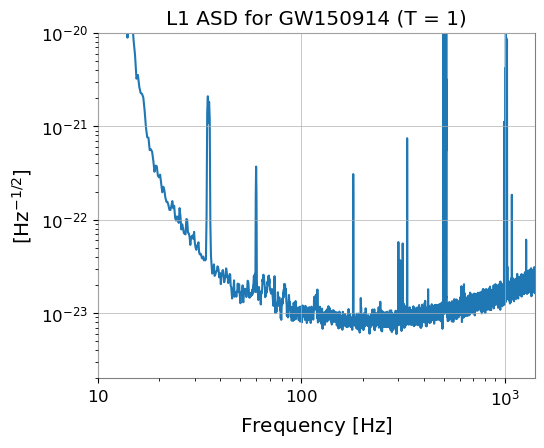

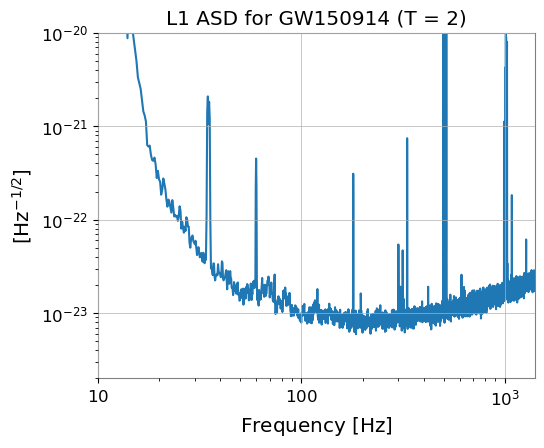

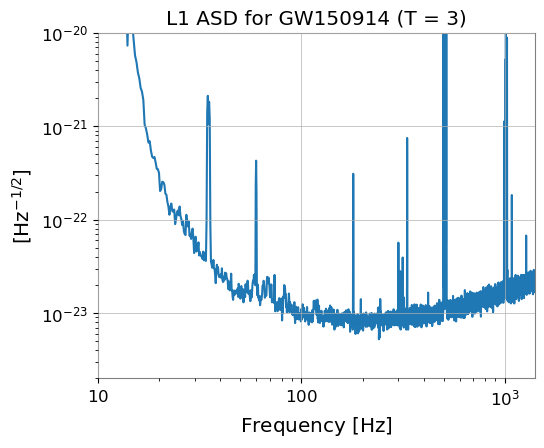

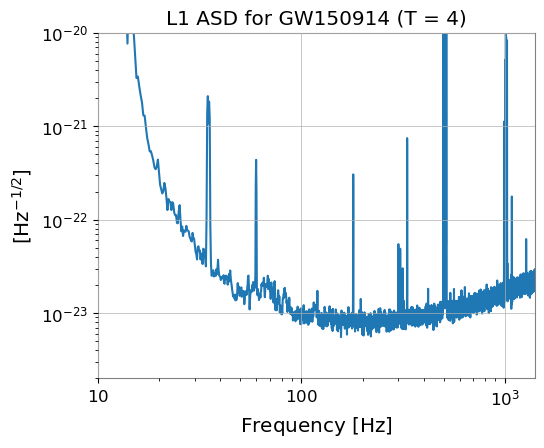

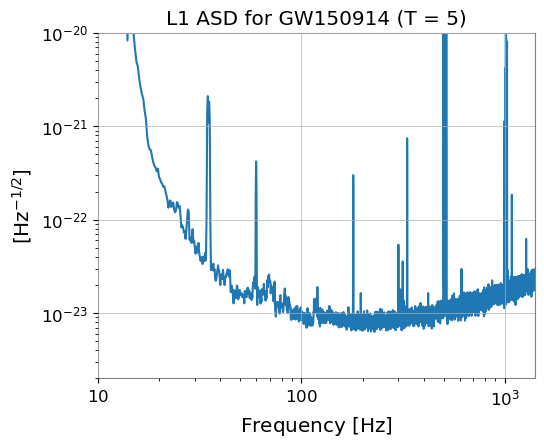

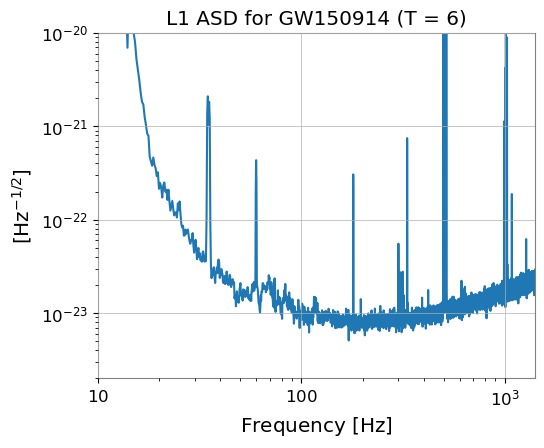

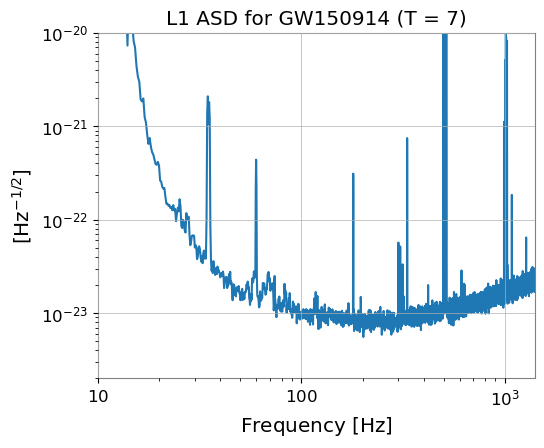

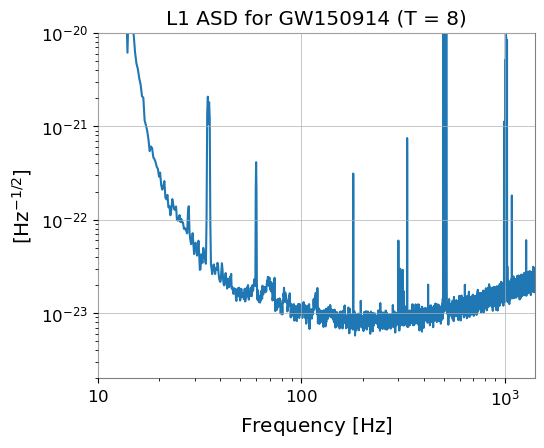

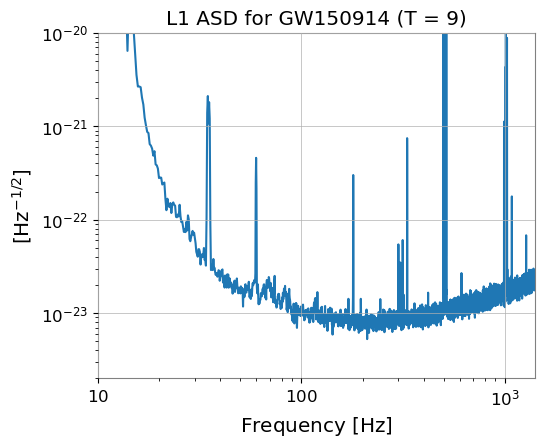

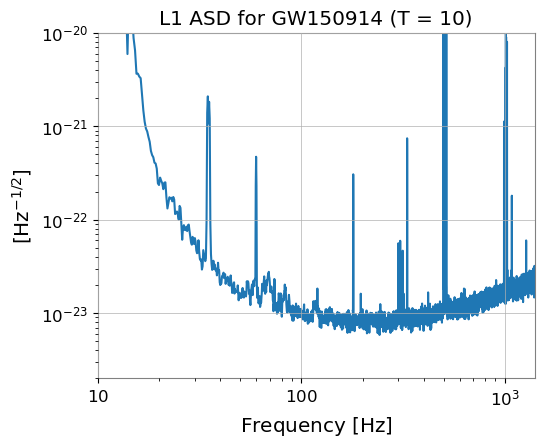

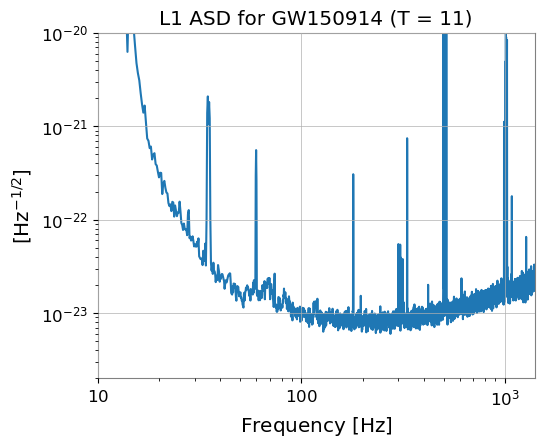

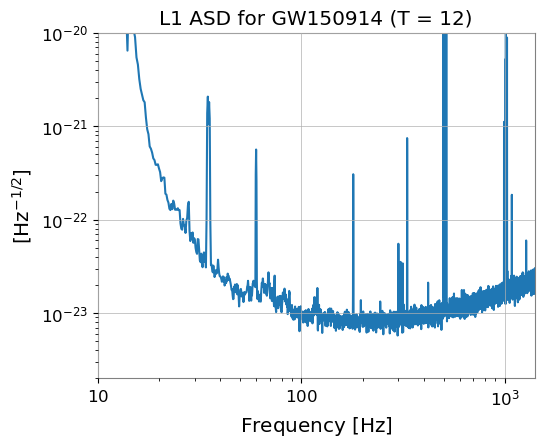

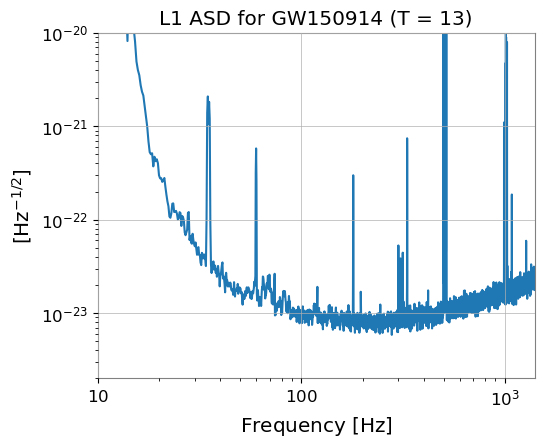

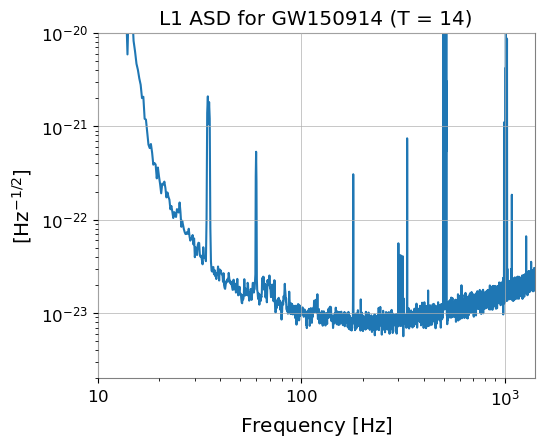

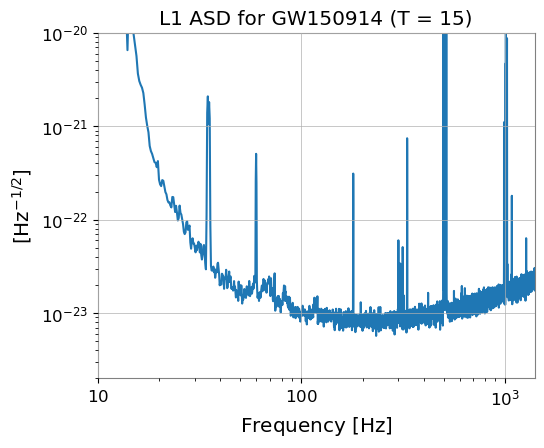

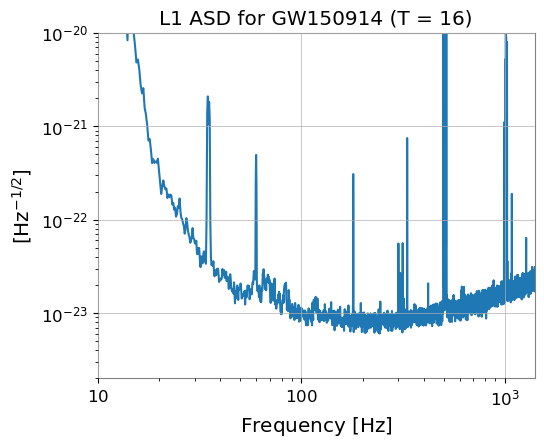

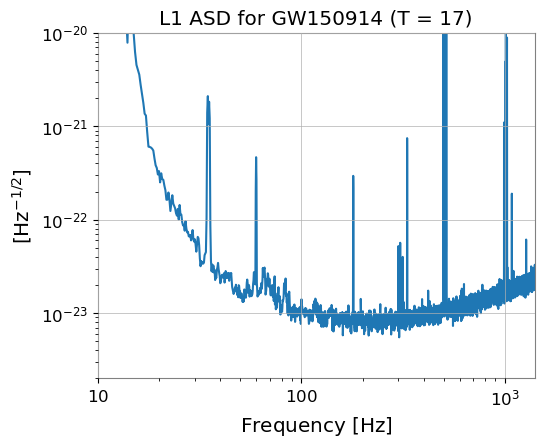

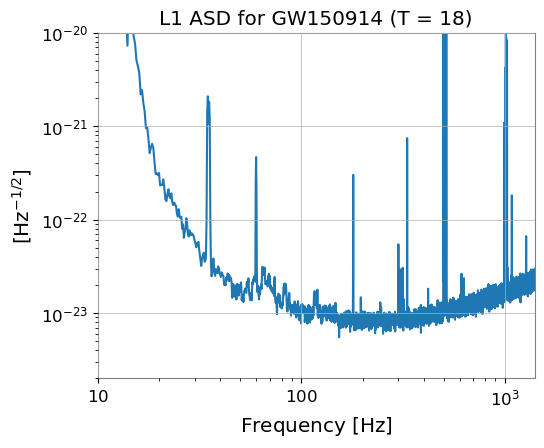

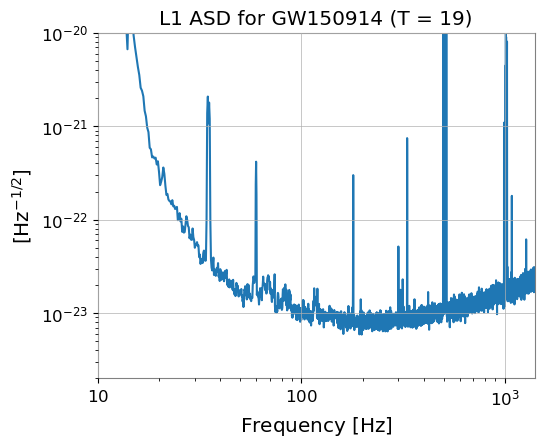

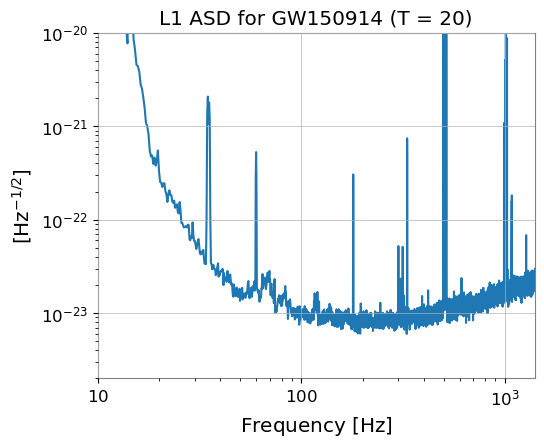

In [9]:
# ASD for each sample
for i, sample in enumerate(sample_data):
    asd = sample.asd(fftlength=4, method="median")
    plot = asd.plot()

    ax = plot.gca()
    ax.set_xlim(10, 1400)
    ax.set_ylim(2e-24, 1e-20)
    ax.set_title(ev_ifo + " ASD for " + ev_name + " (T = %d)" % (i+1))

    #plot.refresh()
    plot.show()

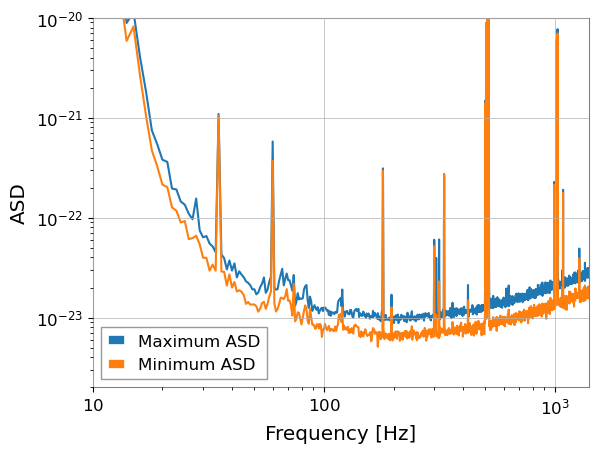

<Figure size 640x480 with 0 Axes>

In [10]:
# frequency band width
band_width = 1  # band width in Hz
frequency_min = 10
frequency_max = 1400
num_bands = int((frequency_max - frequency_min) / band_width)
max_asd = []
min_asd = []
frequency = []

for i in range(num_bands):
    freq = frequency_min + i * band_width
    frequencies = []

    # iterate
    for sample in sample_data:
        asd = sample.asd(fftlength=4, method="median")
        freqs = asd.frequencies.value
        asd_values = asd.value
        index = np.where(freqs == freq)[0]

        # check if the frequency exists in the data
        if len(index) > 0:
            asd_freq = asd_values[index[0]]
            frequencies.append(asd_freq)

    max_asd_value = np.max(frequencies) if len(frequencies) > 0 else np.nan
    min_asd_value = np.min(frequencies) if len(frequencies) > 0 else np.nan
    max_asd.append(max_asd_value)
    min_asd.append(min_asd_value)
    frequency.append(freq)

x_values = frequency

# plot the maximum and minimum ASD values as a function of the frequency
plt.plot(frequency, max_asd, label="Maximum ASD")
plt.plot(frequency, min_asd, label="Minimum ASD")

plt.xlim(10, 1400)
plt.ylim(2e-24, 1e-20)
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD")
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.show()
out_name = os.path.join(results_dir,"L1_ASD_frequency.png")
plt.savefig(out_name)

Average and Standard deviation: 2.376346667426446e-23 6.398413565916153e-23


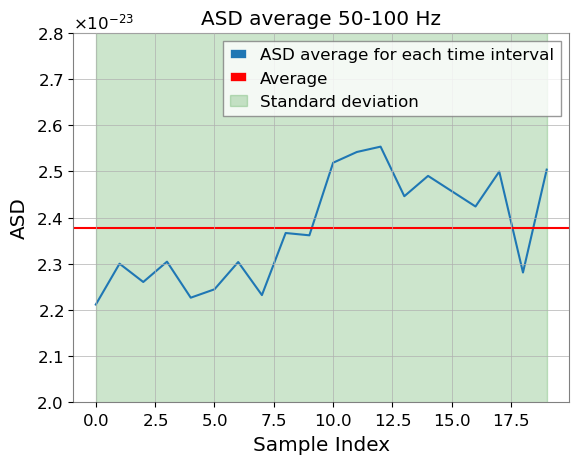

<Figure size 640x480 with 0 Axes>

In [17]:
band_width = 1  # band width in Hz
frequency_min = 50
frequency_max = 100

asd_all = []
nasd_average = []

for sample in sample_data:
    asd = sample.asd(fftlength=4, method="median")
    freqs = asd.frequencies.value
    asd_values = asd.value
    asd_list = []

    for freq in range(frequency_min, frequency_max + 1):
        index = np.where(freqs == freq)[0]

        if len(index) > 0:
            asd_value = asd_values[index[0]]
            asd_list.append(asd_value)
            asd_all.append(asd_value)

    average = np.mean(asd_list)
    nasd_average.append(average)

asd_average = np.mean(asd_all)
asd_std = np.std(asd_all)

print("Average and Standard deviation:", asd_average, asd_std)


plt.plot(range(len(sample_data)), nasd_average, label="ASD average for each time interval")
plt.axhline(y=asd_average, color='r', linestyle='-', label="Average")
plt.fill_between(range(len(sample_data)), asd_average - asd_std, asd_average + asd_std, color='green', alpha=0.2, label="Standard deviation")


#plt.xlim(0, len(sample_data) - 1)
plt.ylim(2e-23, 2.8e-23)
plt.xlabel("Sample Index")
plt.ylabel("ASD")
plt.title("ASD average 50-100 Hz")
plt.legend()


plt.show()
out_name = os.path.join(results_dir,"L1_ASD_average.png")
plt.savefig(out_name)

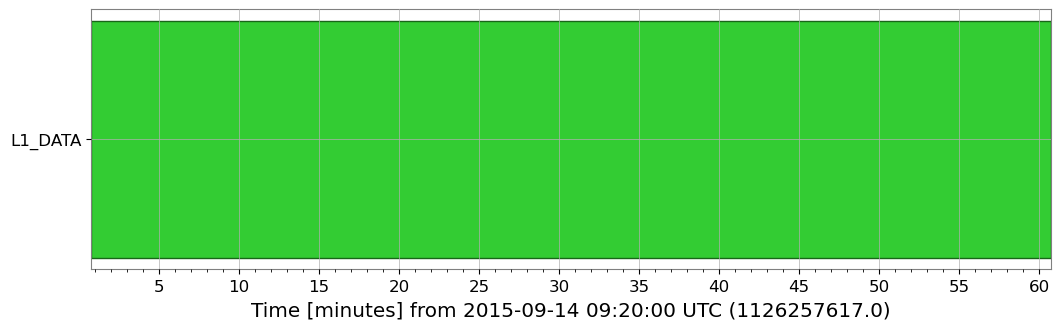

In [18]:
#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)

#Green is data ok, red is data bad.
plot = segments.plot()
out_name = os.path.join(results_dir,"L1_data_green.png")
plt.savefig(out_name)

/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


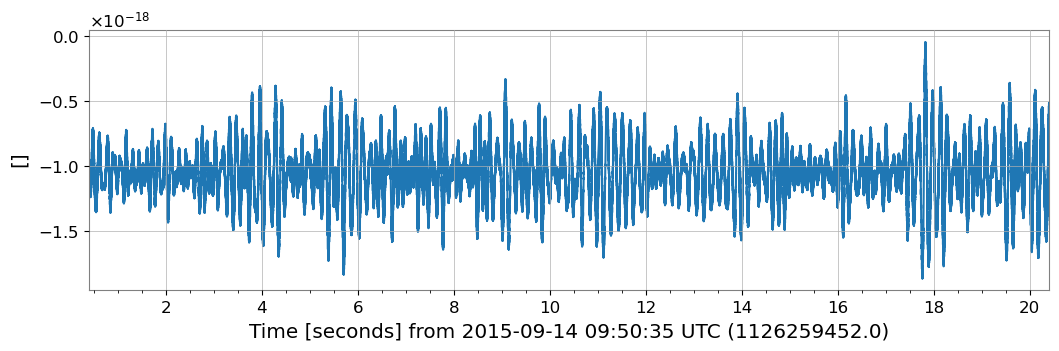

In [19]:
from gwpy.plot import Plot

# Select a time interval of 20 second around the event. This is because on GWOSC there is 1 hour data window released around events
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data_opt = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#Plot raw data   
plot_data=data_opt.plot()
plot_data.show()

out_name = os.path.join(results_dir,"L1_data_20sec.png")
plt.savefig(out_name)

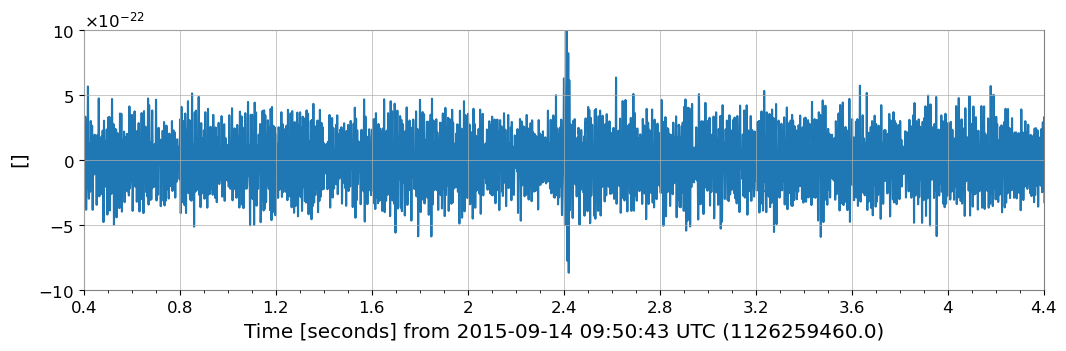

In [20]:
#then a medium frequency filter. Something is visible?
#One can also apply a notch filter in order to remove specific lines (in this case the power line at 60 Hz)
data_filtered=data_opt.bandpass(64,300).notch(60)

plot = data_filtered.plot()
ax = plot.gca()

#zoom around the event(ex. 2 second). Can we see something now?
ax.set_xlim(ev_gps-2,ev_gps+2)
ax.set_ylim(-1e-21,1e-21)
plot.refresh()

out_name = os.path.join(results_dir,"L1_data_filtered.png")
plt.savefig(out_name)

### 3. Signal search with template matching
Now you will use the PyCBC package to to build a signal template and apply a matched filter. This is a simple way to reproduce the detection procedure of CBC signals.

In [17]:
### 1.

In [21]:
# Select +/- 10 seconds around the event
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
print("Done")

Get data for GW150914 (L1) GPS: 1126259452.40 - 1126259472.40


/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


Done


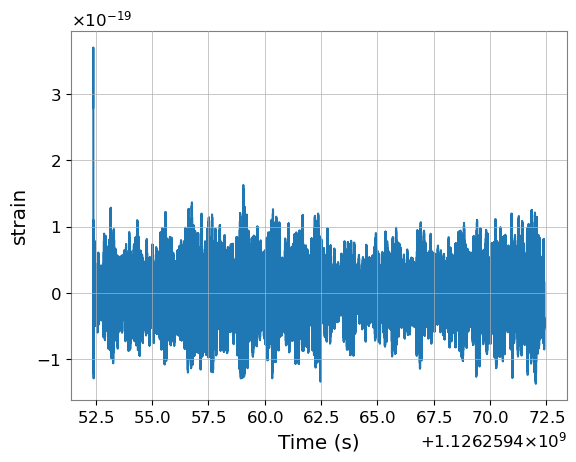

In [22]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass


# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)#1.0/2048 = 0.00048828125

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

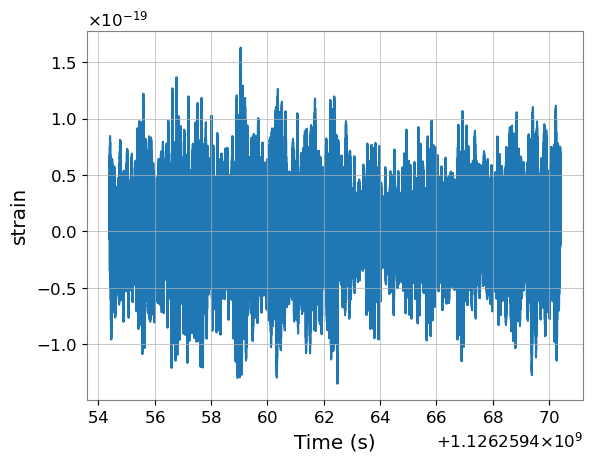

<Figure size 640x480 with 0 Axes>

In [23]:
# Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

out_name = os.path.join(results_dir,"L1_data_filtered_2sec.png")
plt.savefig(out_name)

In [24]:
### 2. and 3. 

conditioned.delta_t : 0.00048828125
hp.sample_times : [-2.9633316  -2.96284332 -2.96235504 ... 13.03520355 13.03569183
 13.03618012]


Text(0, 0.5, 'Strain')

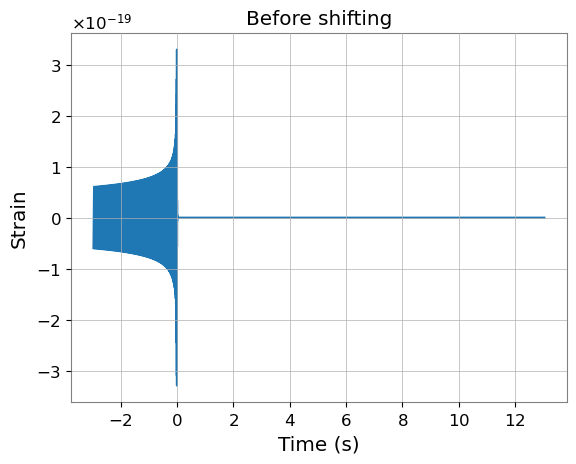

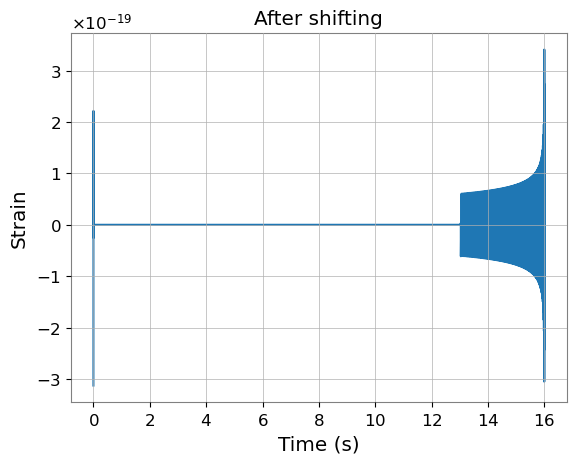

In [25]:
from pycbc.waveform import get_td_waveform

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW170814.
m_guess1 = 15 # Solar masses
m_guess2 = 15 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m_guess1,
                     mass2=m_guess2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

#data has +/- 10 second around the event
print("conditioned.delta_t :", conditioned.delta_t)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

print('hp.sample_times :', hp.sample_times)

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

conditioned.delta_t : 0.00048828125
hp.sample_times : [-1.7808876  -1.78039932 -1.77991104 ... 14.21764755 14.21813584
 14.21862412]


Text(0, 0.5, 'Strain')

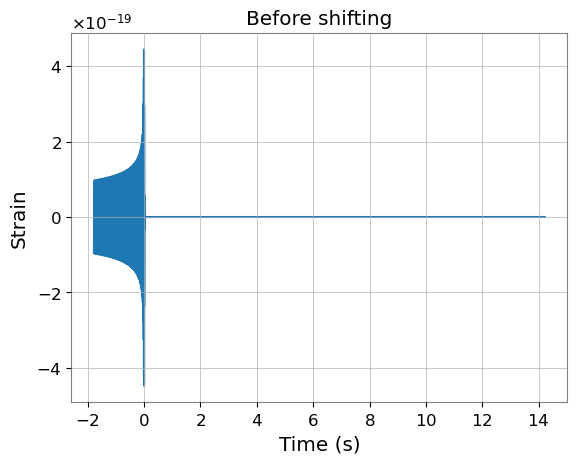

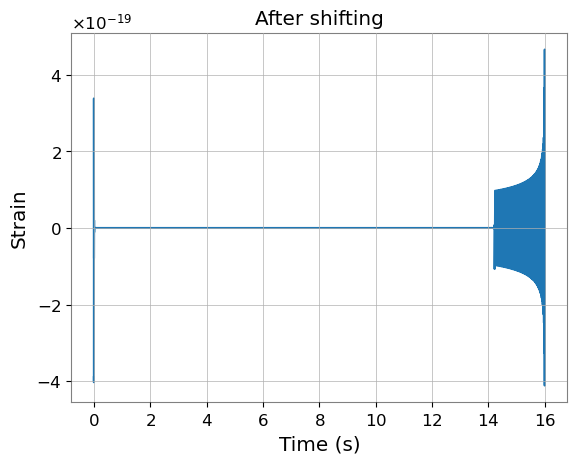

In [26]:
m_guess1 = 20 # Solar masses
m_guess2 = 20 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m_guess1,
                     mass2=m_guess2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

#data has +/- 10 second around the event
print("conditioned.delta_t :", conditioned.delta_t)

# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

print('hp.sample_times :', hp.sample_times)

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

conditioned.delta_t : 0.00048828125
hp.sample_times : [-1.18878613 -1.18829784 -1.18780956 ... 14.80974903 14.81023731
 14.81072559]


Text(0, 0.5, 'Strain')

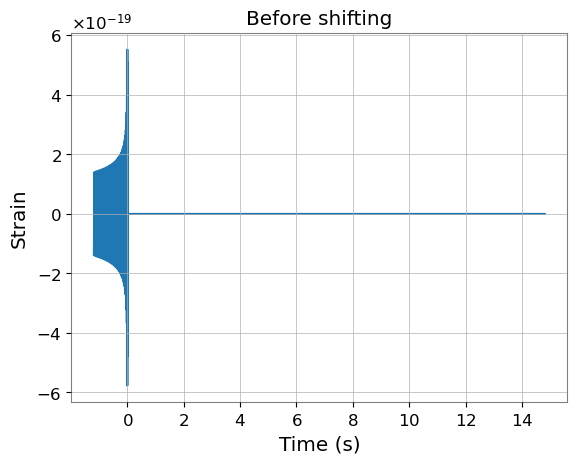

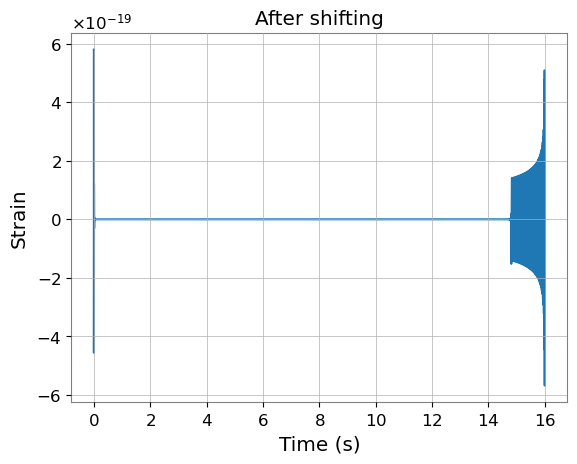

In [27]:
m_guess1 = 25 # Solar masses
m_guess2 = 25 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m_guess1,
                     mass2=m_guess2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

#data has +/- 10 second around the event
print("conditioned.delta_t :", conditioned.delta_t)

# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

print('hp.sample_times :', hp.sample_times)

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

In [28]:
#We can calculate the ASD and PSD also with pyCBC

from pycbc.psd import interpolate, inverse_spectrum_truncation

# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

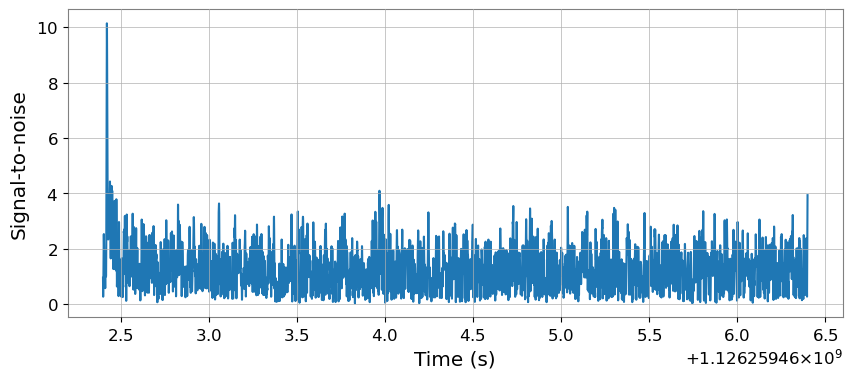

We found a signal at 1126259462.421875s with SNR 10.137865514966228


In [29]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

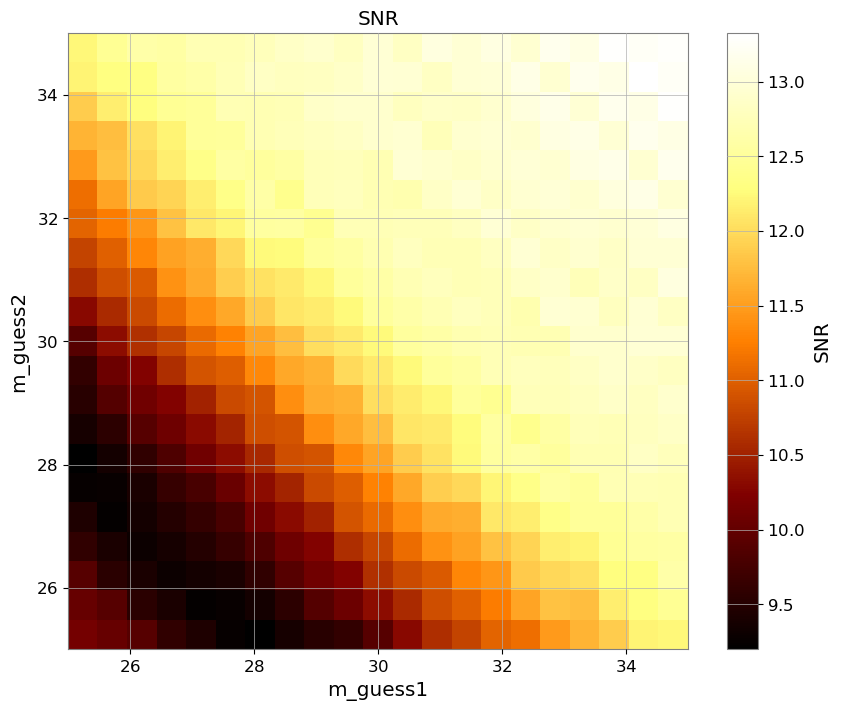

We found the maxium signal at 1126259462.418457s with SNR 13.323155472013713
m_guess1 at maximum SNR: 34.5
m_guess2 at maximum SNR: 34.5


<Figure size 640x480 with 0 Axes>

In [34]:
# Set the initial values and steps for m_guess1 and m_guess2
m_guess1_start = 25
m_guess1_end = 35
m_guess1_step = 0.5

m_guess2_start = 25
m_guess2_end = 35
m_guess2_step = 0.5

m_guess1_range = np.arange(m_guess1_start, m_guess1_end + m_guess1_step, m_guess1_step)
m_guess2_range = np.arange(m_guess2_start, m_guess2_end + m_guess2_step, m_guess2_step)

snr_matrix = np.zeros((len(m_guess1_range), len(m_guess2_range)))

max_snr = 0
max_peak = 0
max_time = 0
max_template = 0
max_m_guess1 = 0
max_m_guess2 = 0

# calculate SNR for each combination
for i, m_guess1 in enumerate(m_guess1_range):
    for j, m_guess2 in enumerate(m_guess2_range):
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=m_guess1,
                                 mass2=m_guess2,
                                 delta_t=conditioned.delta_t,
                                 f_lower=20)
        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)
        snr = matched_filter(template, conditioned,
                             psd=psd, low_frequency_cutoff=20)
        snr = snr.crop(4 + 4, 4)
        peak = abs(snr).numpy().argmax()
        time = snr.sample_times[peak]
        snrp = abs(snr)[peak]
        snr_matrix[i, j] = snrp
        
        if snrp > max_snr:
            max_snr = snrp
            max_peak = peak
            max_time = time
            max_template = template
            max_m_guess1 = m_guess1
            max_m_guess2 = m_guess2

# 2D plot
plt.figure(figsize=[10, 8])
plt.imshow(snr_matrix.T, origin='lower', aspect='auto',
           extent=[m_guess1_start, m_guess1_end, m_guess2_start, m_guess2_end], cmap='afmhot')
plt.colorbar(label='SNR')
plt.xlabel('m_guess1')
plt.ylabel('m_guess2')
plt.title('SNR')

plt.show()

out_name = os.path.join(results_dir,"L1_SNR_m1_m2.png")
plt.savefig(out_name)

print("We found the maxium signal at {}s with SNR {}".format(max_time, abs(max_snr)))
print("m_guess1 at maximum SNR: {}".format(max_m_guess1))
print("m_guess2 at maximum SNR: {}".format(max_m_guess2))

In [ ]:
### 4.

In [35]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
import numpy
m_guess1 = max_m_guess1 
m_guess2 = max_m_guess2
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m_guess1,
                     mass2=m_guess2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [36]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

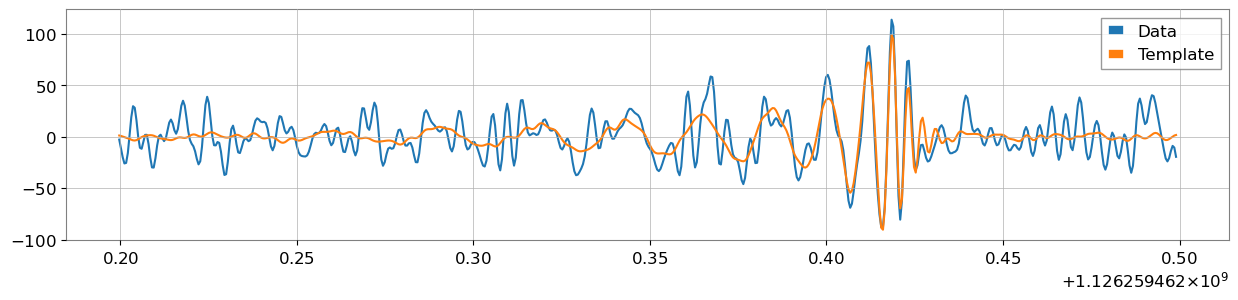

<Figure size 640x480 with 0 Axes>

In [38]:
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data

white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()


out_name = os.path.join(results_dir,"L1_data_template.png")
plt.savefig(out_name)